**The name LSTWR stands for Long/Short Term Word Recommender**

We are going to train the model using the adventures sherlock holmes (my favorite novel)

In [1]:
from numpy import unique, zeros, asarray, log, exp, sum
from nltk.tokenize import RegexpTokenizer #We are going to tokenize the text data using regex rules

In [4]:
book_path = "SherlockHolmes.txt"
with open (book_path) as file:
  content = file.read().lower() #lower case it to remove case sensitivity
  print("content length:", len(content))

content length: 581425


In [5]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(content)
u_words = unique(words) #find the unique words
u_index = dict((c, i) for i, c in enumerate(u_words)) # the index of the uniquue words

In [6]:
word_count = 4 #determines how many of the previous words are used to predict the next word
prev_words = [] #the previous words (the words which have been written before)
next_words = []

#in here we make batches which contain (word_count) words each and put them in the previous words list
#then we add the next word which is the result of the batch to the next words list
for i in range(len(words) - word_count):
    prev_words.append(words[i:i + word_count])
    next_words.append(words[i + word_count])

In [7]:
#An example
print(prev_words[0]) #from these (word_count) words
print(next_words[0]) #this word should be predicted

['the', 'project', 'gutenberg', 'ebook']
of


In [8]:
X = zeros((len(prev_words), word_count, len(u_words)), dtype=bool)
Y = zeros((len(next_words), len(u_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, u_index[each_word]] = 1
    Y[i, u_index[next_words[i]]] = 1

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.backend import clear_session

In [10]:
model_version = "0.0.1"

model = Sequential()
model.add(Input((word_count, len(u_words))))
model.add(LSTM(128))
model.add(Dense(len(u_words)))
model.add(Activation('softmax'))

print(model.summary())
#plot_model(model, to_file='model_plot_v' + model_version + '_w' + str(word_count) + '.png', show_shapes=True, show_layer_names=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │       4,255,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8183)                │       1,055,607 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 8183)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,311,351 (20.26 MB)

 Trainable params: 5,311,351 (20.26 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/2
810/810 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.0624 - loss: 6.5786 - val_accuracy: 0.0885 - val_loss: 6.7774
Epoch 2/2
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1188 - loss: 5.7256 - val_accuracy: 0.1083 - val_loss: 6.6576


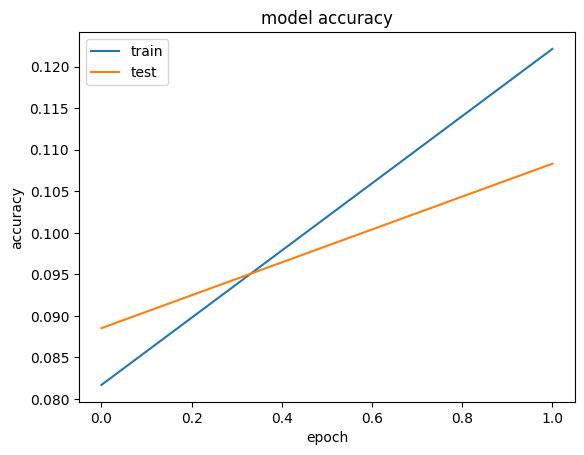

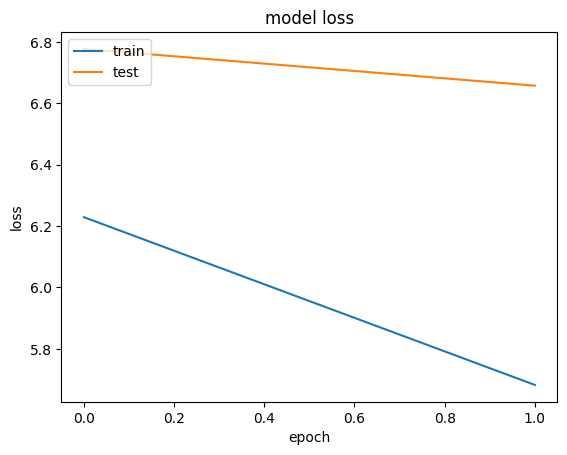

In [11]:
import matplotlib.pyplot as plt

clear_session() #clear the model so that it does not get trained with prior knowledge
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history
model.save('LSTWR_v' + model_version + '_w' + str(word_count) + '.keras')

#plot model accuracy history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plot model loss history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
from heapq import nlargest

#converts the input text into a valid model input
def text_to_input(text):
    x = zeros((1, word_count, len(u_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, u_index[word]] = 1
    return x

#returns the best possible n words after the prediction from the model
def sample(preds, top_n=word_count):
    preds = asarray(preds).astype('float64')
    preds = log(preds)
    exp_preds = exp(preds)
    preds = exp_preds / sum(exp_preds)

    return nlargest(top_n, range(len(preds)), preds.take)

def predict_completions(text, n=word_count):
    if text == "":
        return("0")
    x = text_to_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [u_words[idx] for idx in next_indices]

In [14]:
query = "Holmes had sat up upon the couch, and I saw him motion"
print("Full sentence:", query)
seq = " ".join(tokenizer.tokenize(query.lower())[0:word_count])
print("Input sequence: ",seq)
print("next possible words: ", predict_completions(seq, 3))

Full sentence: Holmes had sat up upon the couch, and I saw him motion
Input sequence:  holmes had sat up
holmes
had
sat
up
next possible words:  ['the', 'his', 'upon']
